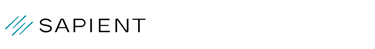

# Sapient Data Science Test Project

Kendall McNeil, January 2024

# A. Project Description

- DISEASE FOCUS: In a public health study, participants were enrolled from communities for physical exams, blood tests, and were followed up for years with disease outcomes. We are interested in investigating blood biomarkers for a prevalent and detrimental disease – diabetes. 

- EXISTING/INCIDENT_DIABETES: A portion of the participants were already diagnosed to have diabetes at the time of enrollment (baseline). These participants have “existing_diabetes” outcome as 1. Some participants later on developed diabetes during the follow up period of the study. We call these new development of diabetes “incident_diabetes”. 

- DIABETES_TIME: For participants with incident diabetes, “diabetes_time” indicates the number of years it took to develop diabetes since baseline enrollment. For participants with existing diabetes, “diabetes_time” is negative and indicates the number of years the diagnosis of diabetes was made prior to baseline enrollment. For participants without diabetes at any time, “diabetes_time” indicates the number of years of follow up time since enrollment.

- DEMOGRAPHIC INFO: Demographic variables include age, sex, and body-mass-index (BMI).

- MTB: Blood biomarkers are denoted as “mtb_*”. When there is a missing value for blood biomarkers, it is usually due to the extremely low abundance of that biomarker in blood samples which could be below the lower limit of detection.

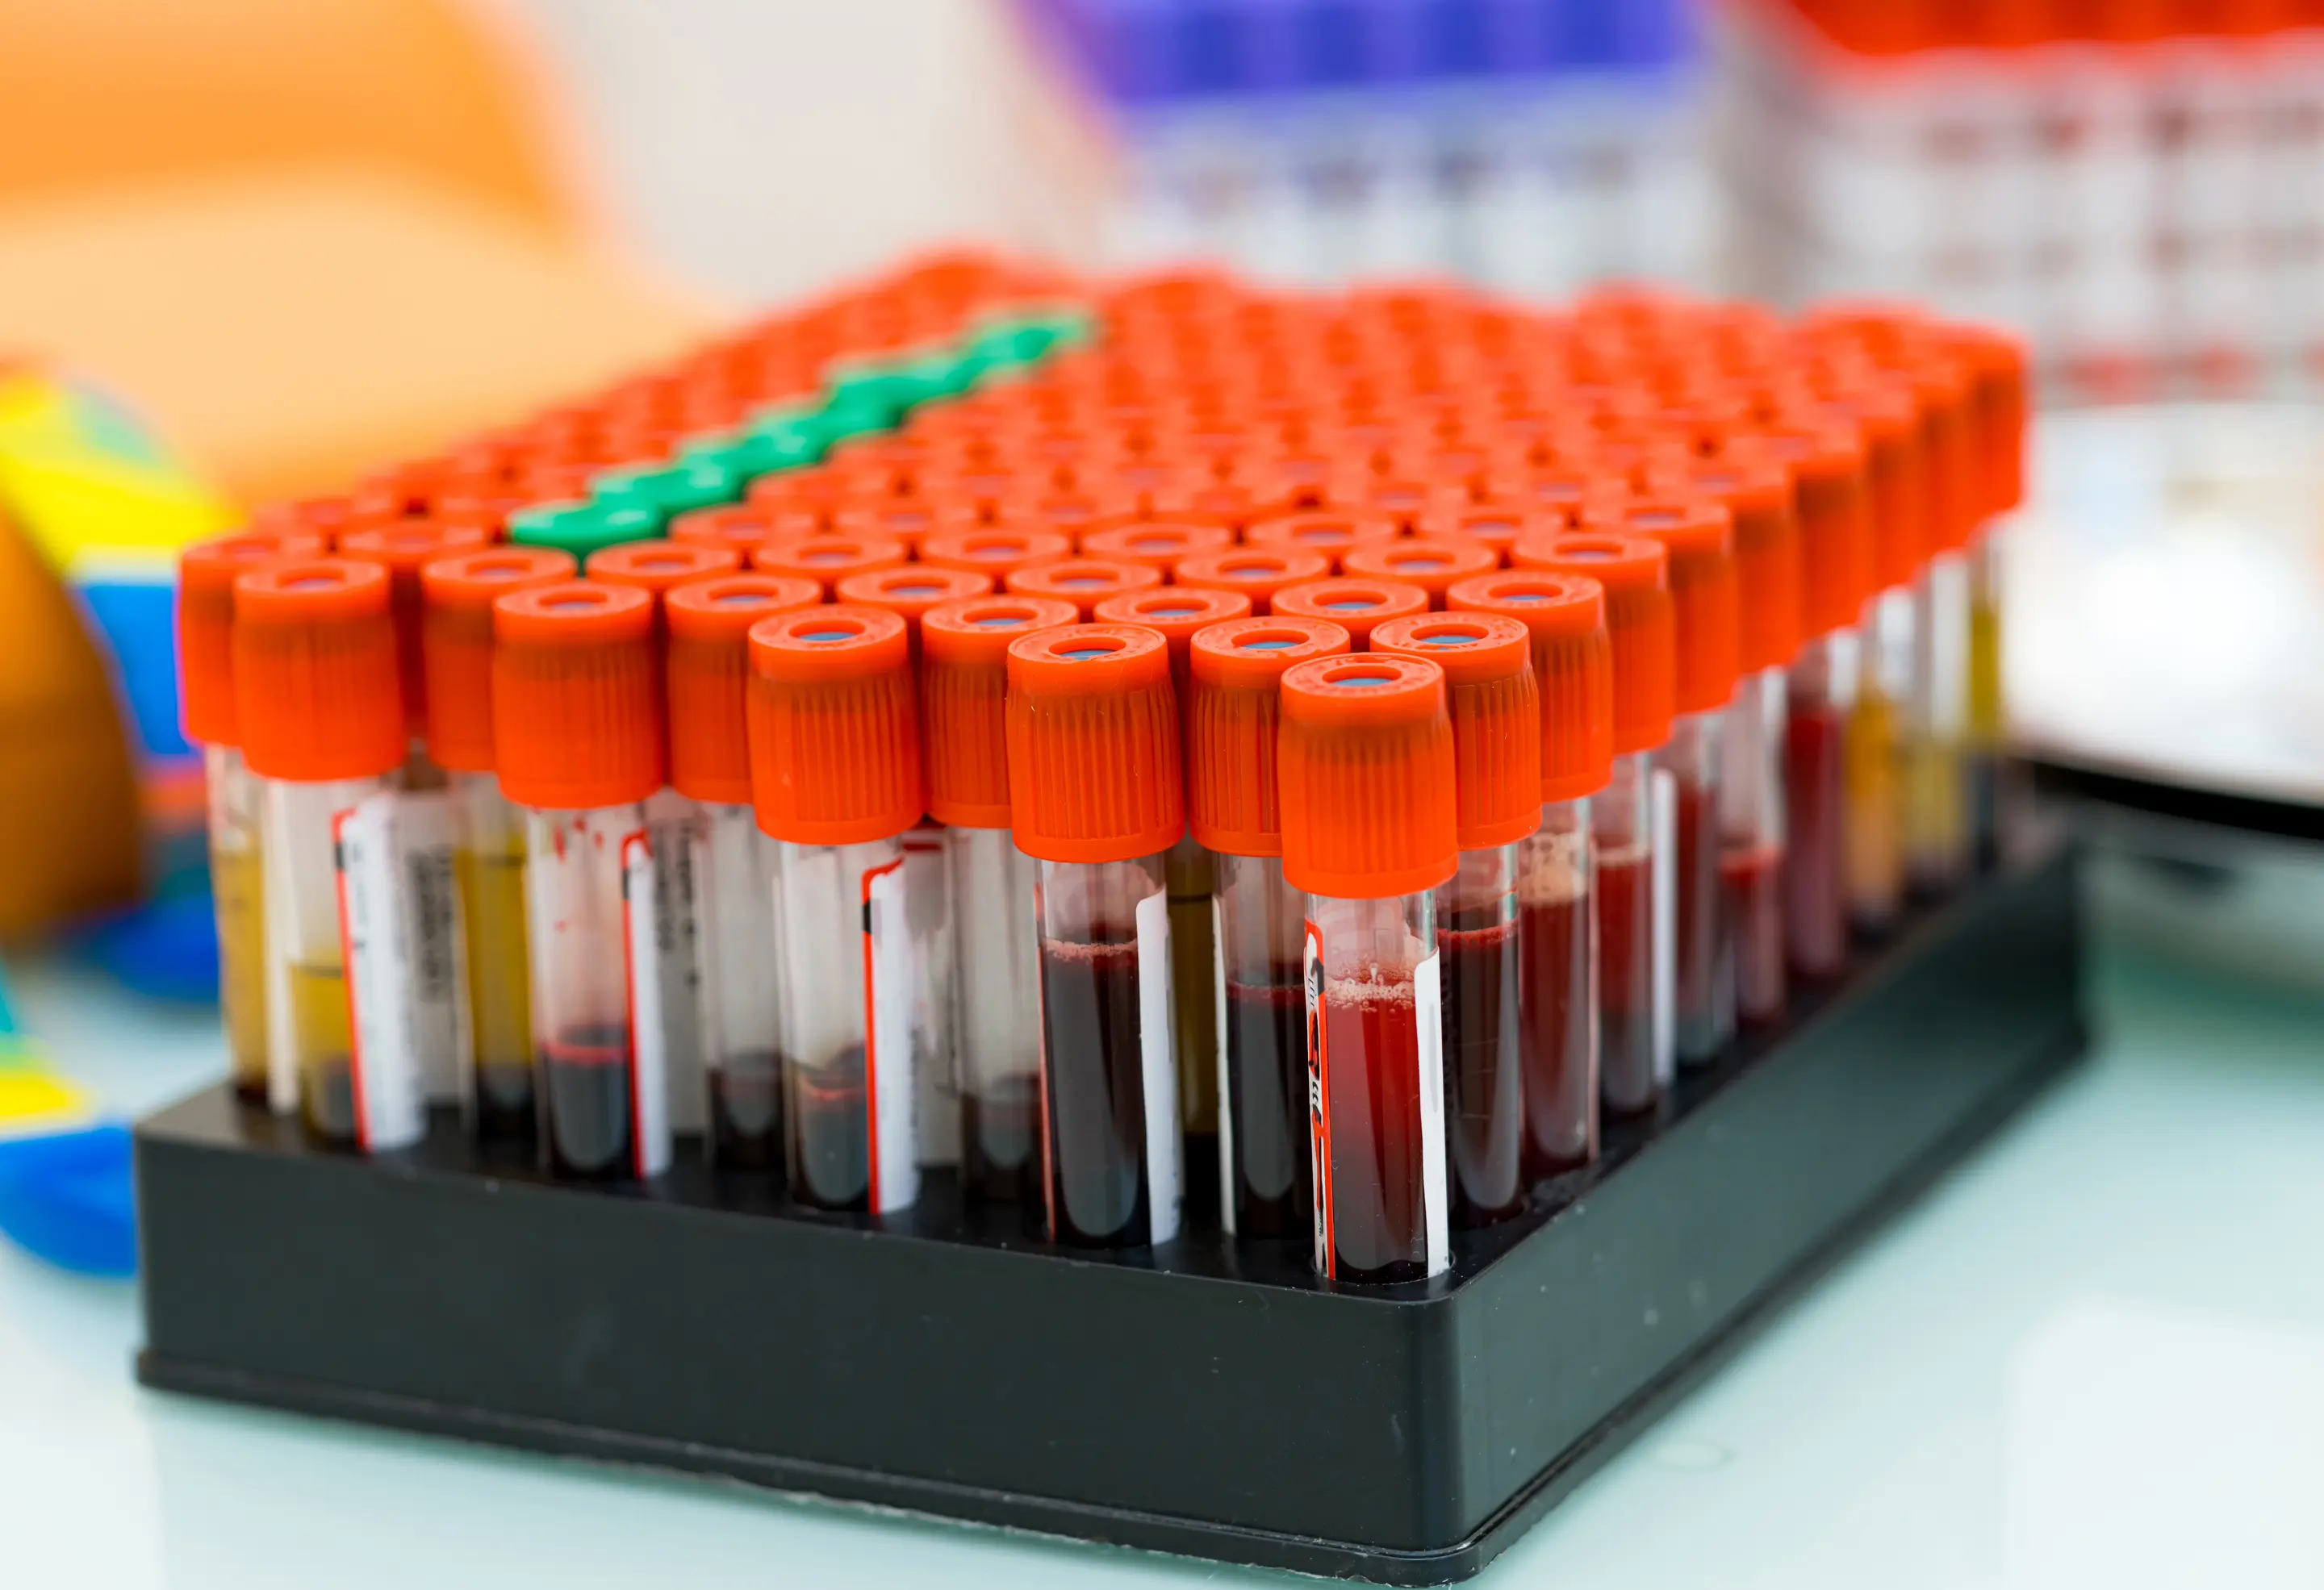

---

# B. Setup, Cleaning, and EDA

## B1. Setup

In [174]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
sns.set(style="darkgrid")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [119]:
data = pd.read_csv('test_project_data.csv')
data.head()

,subject_id,mtb_0018261,mtb_0018266,mtb_0018325,mtb_0018326,mtb_0018327,mtb_0018351,mtb_0018362,mtb_0018470,mtb_0018509,...,mtb_2127305,mtb_2129124,mtb_2129210,mtb_2129554,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time
0,sbj_0000,5885.011,15177.95,19653.31,12611.670,9042.063,NaN,60124.56,9552.881,NaN,...,NaN,NaN,22112.25,NaN,18.664268,33.81,male,0.0,0.0,14.77
1,sbj_0001,7624.425,10901.94,12129.36,9336.460,21680.930,NaN,83700.80,15068.120,NaN,...,NaN,NaN,NaN,NaN,28.175977,68.56,male,0.0,0.0,14.77
2,sbj_0002,7220.400,18086.69,23707.55,7344.697,26314.650,NaN,82482.38,13911.300,NaN,...,15185.790,NaN,19425.35,NaN,22.971959,55.68,male,0.0,0.0,14.77
3,sbj_0003,6797.486,12364.85,17775.76,25836.150,30563.140,NaN,92839.12,11690.130,NaN,...,NaN,NaN,NaN,NaN,21.960370,43.89,female,0.0,0.0,14.78
4,sbj_0004,NaN,19046.33,18701.06,14137.270,27020.920,NaN,85453.69,9579.896,NaN,...,5318.547,NaN,NaN,NaN,40.454949,47.76,male,0.0,0.0,14.86


In [120]:
non_mtb_columns = [column for column in data.columns if not column.startswith("mtb")]
print(f"Names of columns that are not blood biomarkers': \n {non_mtb_columns}")

Names of columns that are not blood biomarkers': 
 ['subject_id', 'BMI', 'age', 'sex', 'prevalent_diabetes', 'incident_diabetes', 'diabetes_followup_time']


To avoid any ambiguity, it seems that in the project description, 'existing_diabetes' corresponds to 'prevalent_diabetes,' and 'diabetes_time' aligns with 'diabetes_followup_time.'

In [121]:
mtb_columns = [column for column in data.columns if column.startswith("mtb")]
mtb_columns_count = len(mtb_columns)
print(f"Number of blood biomarkers included': {mtb_columns_count}")

Number of blood biomarkers included': 10000


## B2. Cleaning: Duplicates

Let's also ensure there are no duplicate blood biomarkers included in the dataset.

In [122]:
data.columns.duplicated().sum()

0

Let's also, of course, check for duplicate subject id values. 

In [123]:
data.duplicated().sum()

0

## B3. Cleaning: Missing Values

Given that nulls in mtb_columns are usually due to the extremely low abundance of that biomarker in blood samples which could be below the lower limit of detection, we will fill in 0 for all null values in these columns.

In [124]:
data[mtb_columns] = data[mtb_columns].fillna(0)

In [125]:
data.isna().sum().sort_values(ascending=False).head(10)

diabetes_followup_time    312
prevalent_diabetes        143
incident_diabetes         143
BMI                         4
mtb_0649415                 0
mtb_0651209                 0
mtb_0650958                 0
mtb_0650891                 0
mtb_0650727                 0
mtb_0650179                 0
dtype: int64

In [126]:
#fill null values in 'diabetes_followup_time' with 0
data['diabetes_followup_time'].fillna(0, inplace=True)

#fill null values in 'BMI' with the average BMI
average_bmi = data['BMI'].mean()
data['BMI'].fillna(average_bmi, inplace=True)

Let's also drop any values in the dataset where our target value is null.

In [127]:
data = data.dropna(subset=['incident_diabetes'])

In [128]:
data = pd.get_dummies(data, columns=['sex'], drop_first=True)

## B4. Exploratory Data Analysis

Let's examine counts for: (1) diabetes before the study commenced, (2) diabetes that developed during the study, and (3) the overall presence of diabetes—both before and during the study.

In [116]:
total_participants = data['subject_id'].count()
print(f"There are {total_participants} total participants in this study.")

There are 8148 total participants in this study.


In [117]:
data['prevalent_diabetes'].sum()

451.0

Sanity check.

In [14]:
data['prevalent_diabetes'].value_counts()

0.0    7697
1.0     451
Name: prevalent_diabetes, dtype: int64

In [131]:
(data['prevalent_diabetes'].value_counts(normalize=True) * 100).round(2)

0.0    94.46
1.0     5.54
Name: prevalent_diabetes, dtype: float64

In [136]:
print(f"Of the {total_participants} participants, {(data['prevalent_diabetes'].value_counts(normalize=True) * 100).round(2)[1]}% (or {data['prevalent_diabetes'].value_counts()[1]} participants) had diabetes when the study began.")

Of the 8148 participants, 5.54% (or 451 participants) had diabetes when the study began.


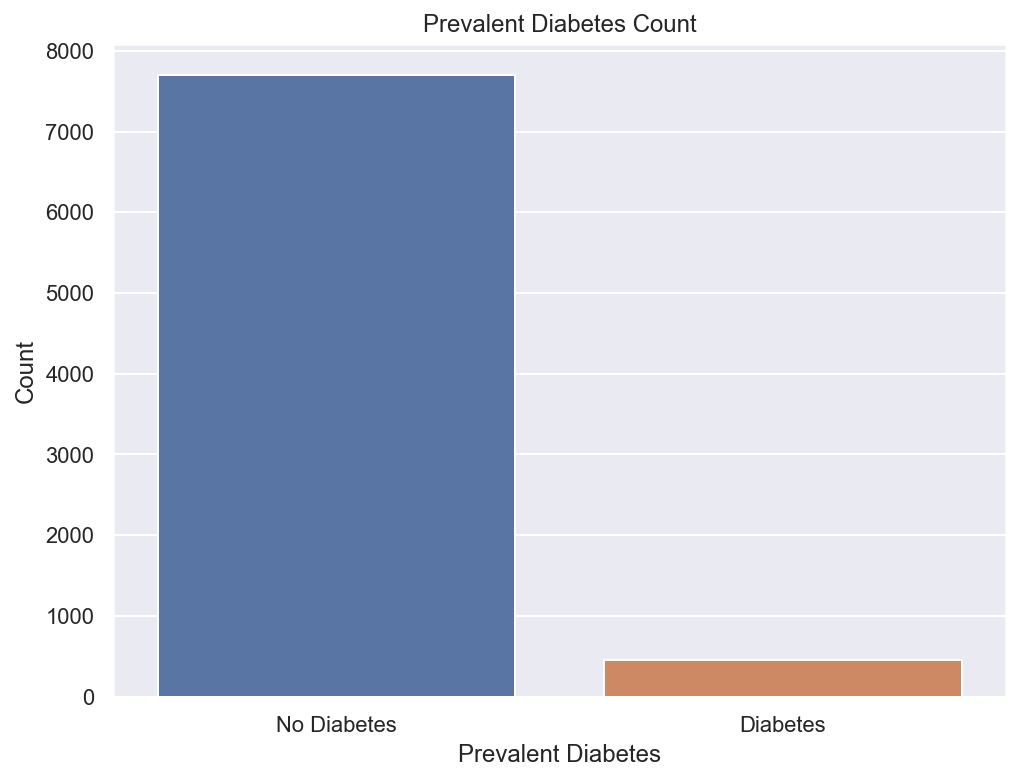

In [16]:
plt.figure(figsize=(8, 6))
sns.countplot(x='prevalent_diabetes', data=data)

plt.title('Prevalent Diabetes Count')
plt.xlabel('Prevalent Diabetes')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])

plt.show()

In [17]:
data['incident_diabetes'].sum()

704.0

In [18]:
data['incident_diabetes'].value_counts()

0.0    7444
1.0     704
Name: incident_diabetes, dtype: int64

In [19]:
(data['incident_diabetes'].value_counts(normalize=True) * 100).round(2)

0.0    91.36
1.0     8.64
Name: incident_diabetes, dtype: float64

In [138]:
print(f"Of the {total_participants} participants, {(data['incident_diabetes'].value_counts(normalize=True) * 100).round(2)[1]}% (or {data['incident_diabetes'].value_counts()[1]} participants) developed diabetes during the study.")

Of the 8148 participants, 8.64% (or 704 participants) developed diabetes during the study.


Assumption Flag: I am assuming that participants who had diabetes at baseline are not included in the incident_diabetes count. Therefore, we will next explore the count for all participants with diabetes. 

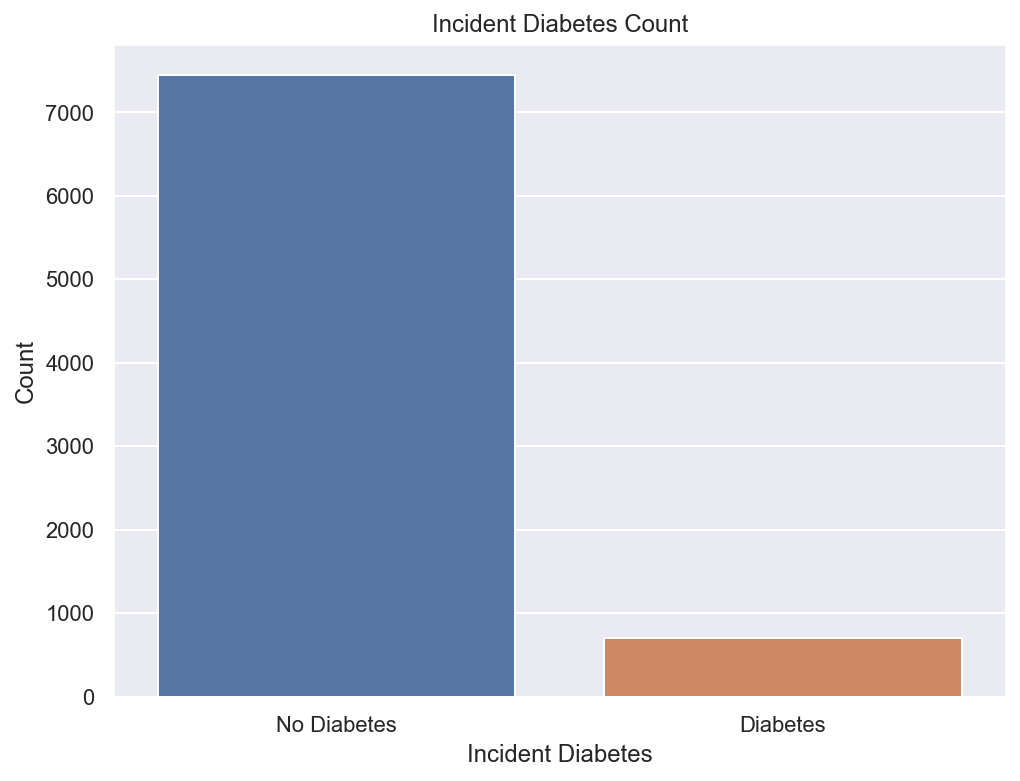

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(x='incident_diabetes', data=data)

plt.title('Incident Diabetes Count')
plt.xlabel('Incident Diabetes')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])

plt.show()

In [21]:
total_diabetes = (data['prevalent_diabetes'] == 1).sum() + (data['incident_diabetes'] == 1).sum()
total_diabetes

1155

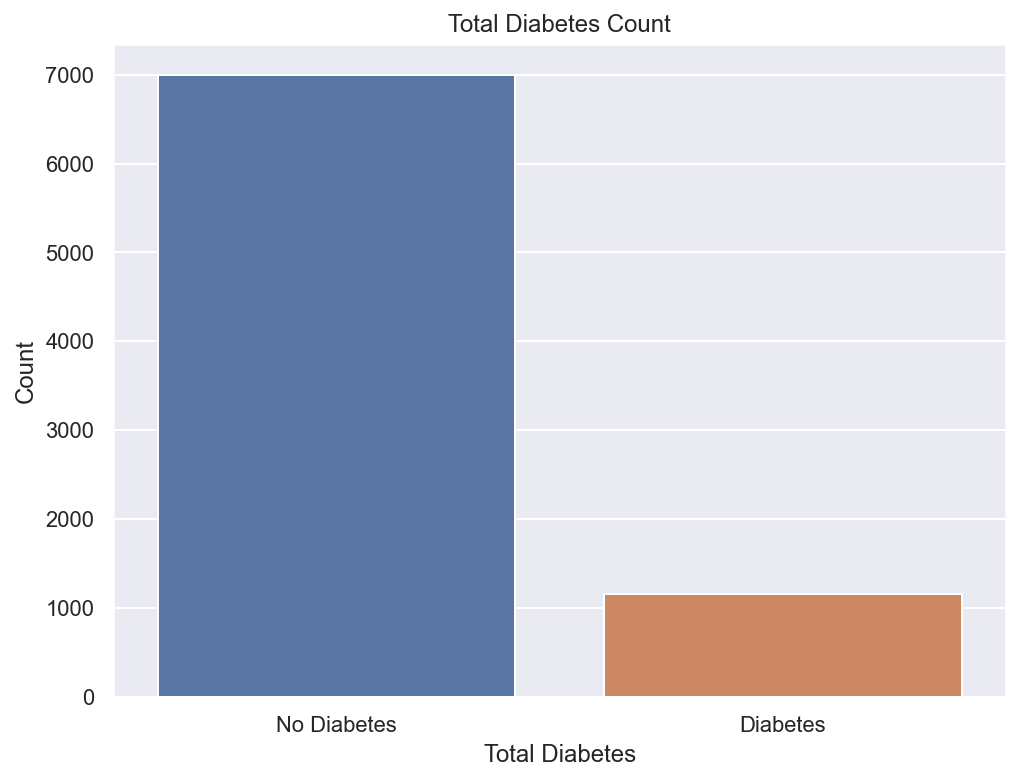

In [22]:
counts_data = {'Total Diabetes': ['No Diabetes', 'Diabetes'],
               'Count': [(total_participants - total_diabetes), total_diabetes]}
counts_df = pd.DataFrame(counts_data)

plt.figure(figsize=(8, 6))
sns.barplot(x='Total Diabetes', y='Count', data=counts_df)

plt.title('Total Diabetes Count')
plt.xlabel('Total Diabetes')
plt.ylabel('Count')

plt.show()

---

# C. Q1: Which blood biomarkers are associated with incident diabetes?

Each of these biomarkers can potentially be a risk or protective factor for diabetes development. Identifiying these biomarkers will help understand the pathways and processes involved in diabetes development thus novel therapeutics can be developed.

Hints: 
- (1) Investigate each blood biomarker individually with covariates and use p-values to justify your findings.
- (2) For blood biomarkers, use transformation that is robust when there are outliers present. 
- (3) Demonstrate your findings with visualization.

---

## C1. Linear Regressions for Each Blood Biomarker

In [46]:
covariates = ['BMI', 'age', 'sex_male', 'prevalent_diabetes', 'diabetes_followup_time']
results = []

for biomarker in mtb_columns:
    #applying log transformation to biomarker data to compress the range of values 
    #and make it less sensitive to extreme values
    X_transformed = np.log1p(data[biomarker])
    X = sm.add_constant(pd.concat([X_transformed, data[covariates]], axis=1))
    model = sm.OLS(data['incident_diabetes'], X).fit()

    result_dict = {
        'biomarker': biomarker,
        'p-value': model.pvalues[1],
        'coef': model.params[1]
    }
    results.append(result_dict)

results_df = pd.DataFrame(results)

In [142]:
results_df.head(10)

,biomarker,p-value,coef
0,mtb_0018261,0.716440,0.000278
1,mtb_0018266,0.268291,0.000657
2,mtb_0018325,0.975317,0.000021
3,mtb_0018326,0.122823,0.000853
4,mtb_0018327,0.448534,-0.000411
5,mtb_0018351,0.952234,0.000038
6,mtb_0018362,0.071665,0.013842
7,mtb_0018470,0.523979,0.000350
8,mtb_0018509,0.873900,-0.000103
9,mtb_0018536,0.597894,0.000465


## C2. Investigating P-Values

- Null Hypothesis (H0): No correlation exists between the given biomarker and incident_diabetes.
- Alternative Hypothesis (H1): Correlation exists between the given biomarker and incident_diabetes. 

In [53]:
significant_biomarkers_05 = results_df[results_df['p-value'] < 0.05]
significant_biomarkers_01 = results_df[results_df['p-value'] < 0.01]
significant_biomarkers_001 = results_df[results_df['p-value'] < 0.001]

In [55]:
print(f"With an alpha of .05, we have {len(significant_biomarkers_05)} statistically significant biomarkers.")
print(f"With an alpha of .01, we have {len(significant_biomarkers_01)} statistically significant biomarkers.")
print(f"With an alpha of .001, we have {len(significant_biomarkers_001)} statistically significant biomarkers.")

With an alpha of .05, we have 1282 statistically significant biomarkers.
With an alpha of .01, we have 595 statistically significant biomarkers.
With an alpha of .001, we have 225 statistically significant biomarkers.


Let's solely look into blood biomarkers that are significant at an alpha of .001 given that there are 225 statistically significant biomarkers. We will leave the other dataframes for possible future analysis.

We must also consider blood biomarkers that are risk (positive correlation with incident_diabetes) and protective (negative correlation with incident diabetes) factors. Let's make sure to evaluate these separately.

In [99]:
top_positive_corr_biomarkers = significant_biomarkers_001.sort_values(by='coef', ascending=False)
top_negative_corr_biomarkers = significant_biomarkers_001.sort_values(by='coef', ascending=True)

### C3. Positive Correlation with Incident Diabetes (RISK)

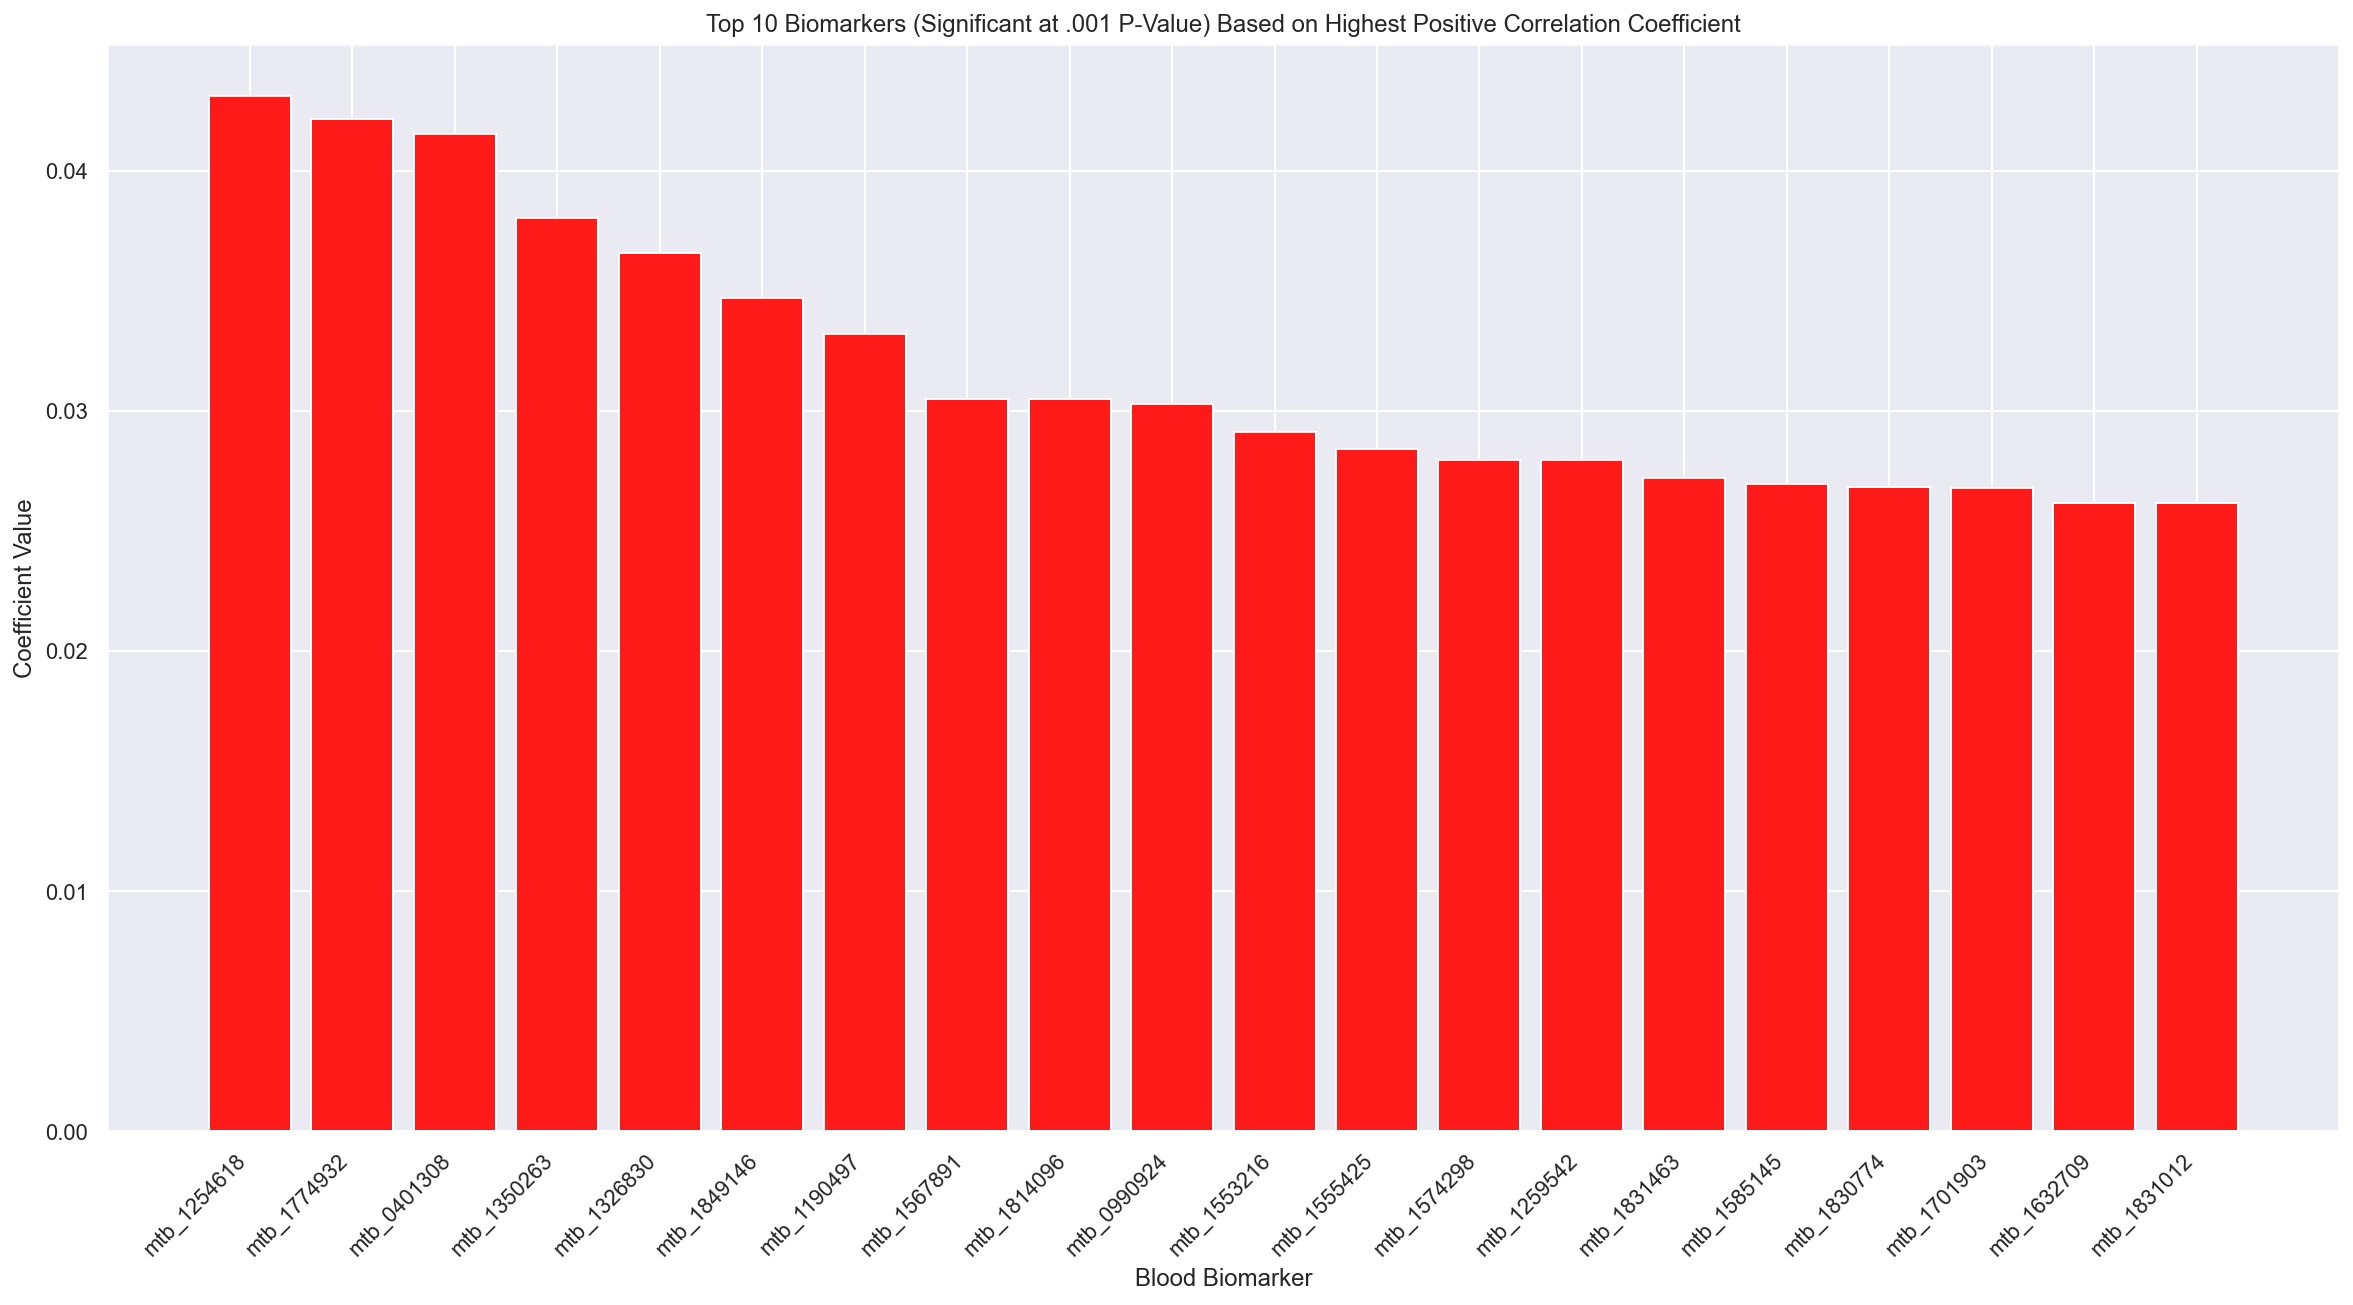

In [165]:
top_20_pos_corr_biomarkers = top_positive_corr_biomarkers.head(20)

plt.figure(figsize=(20, 10))
plt.bar(top_20_pos_corr_biomarkers['biomarker'], top_20_pos_corr_biomarkers['coef'], color=(1.0, 0.1, 0.1))
plt.ylabel('Coefficient Value')
plt.xlabel('Blood Biomarker')
plt.title('Top 10 Biomarkers (Significant at .001 P-Value) Based on Highest Positive Correlation Coefficient')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

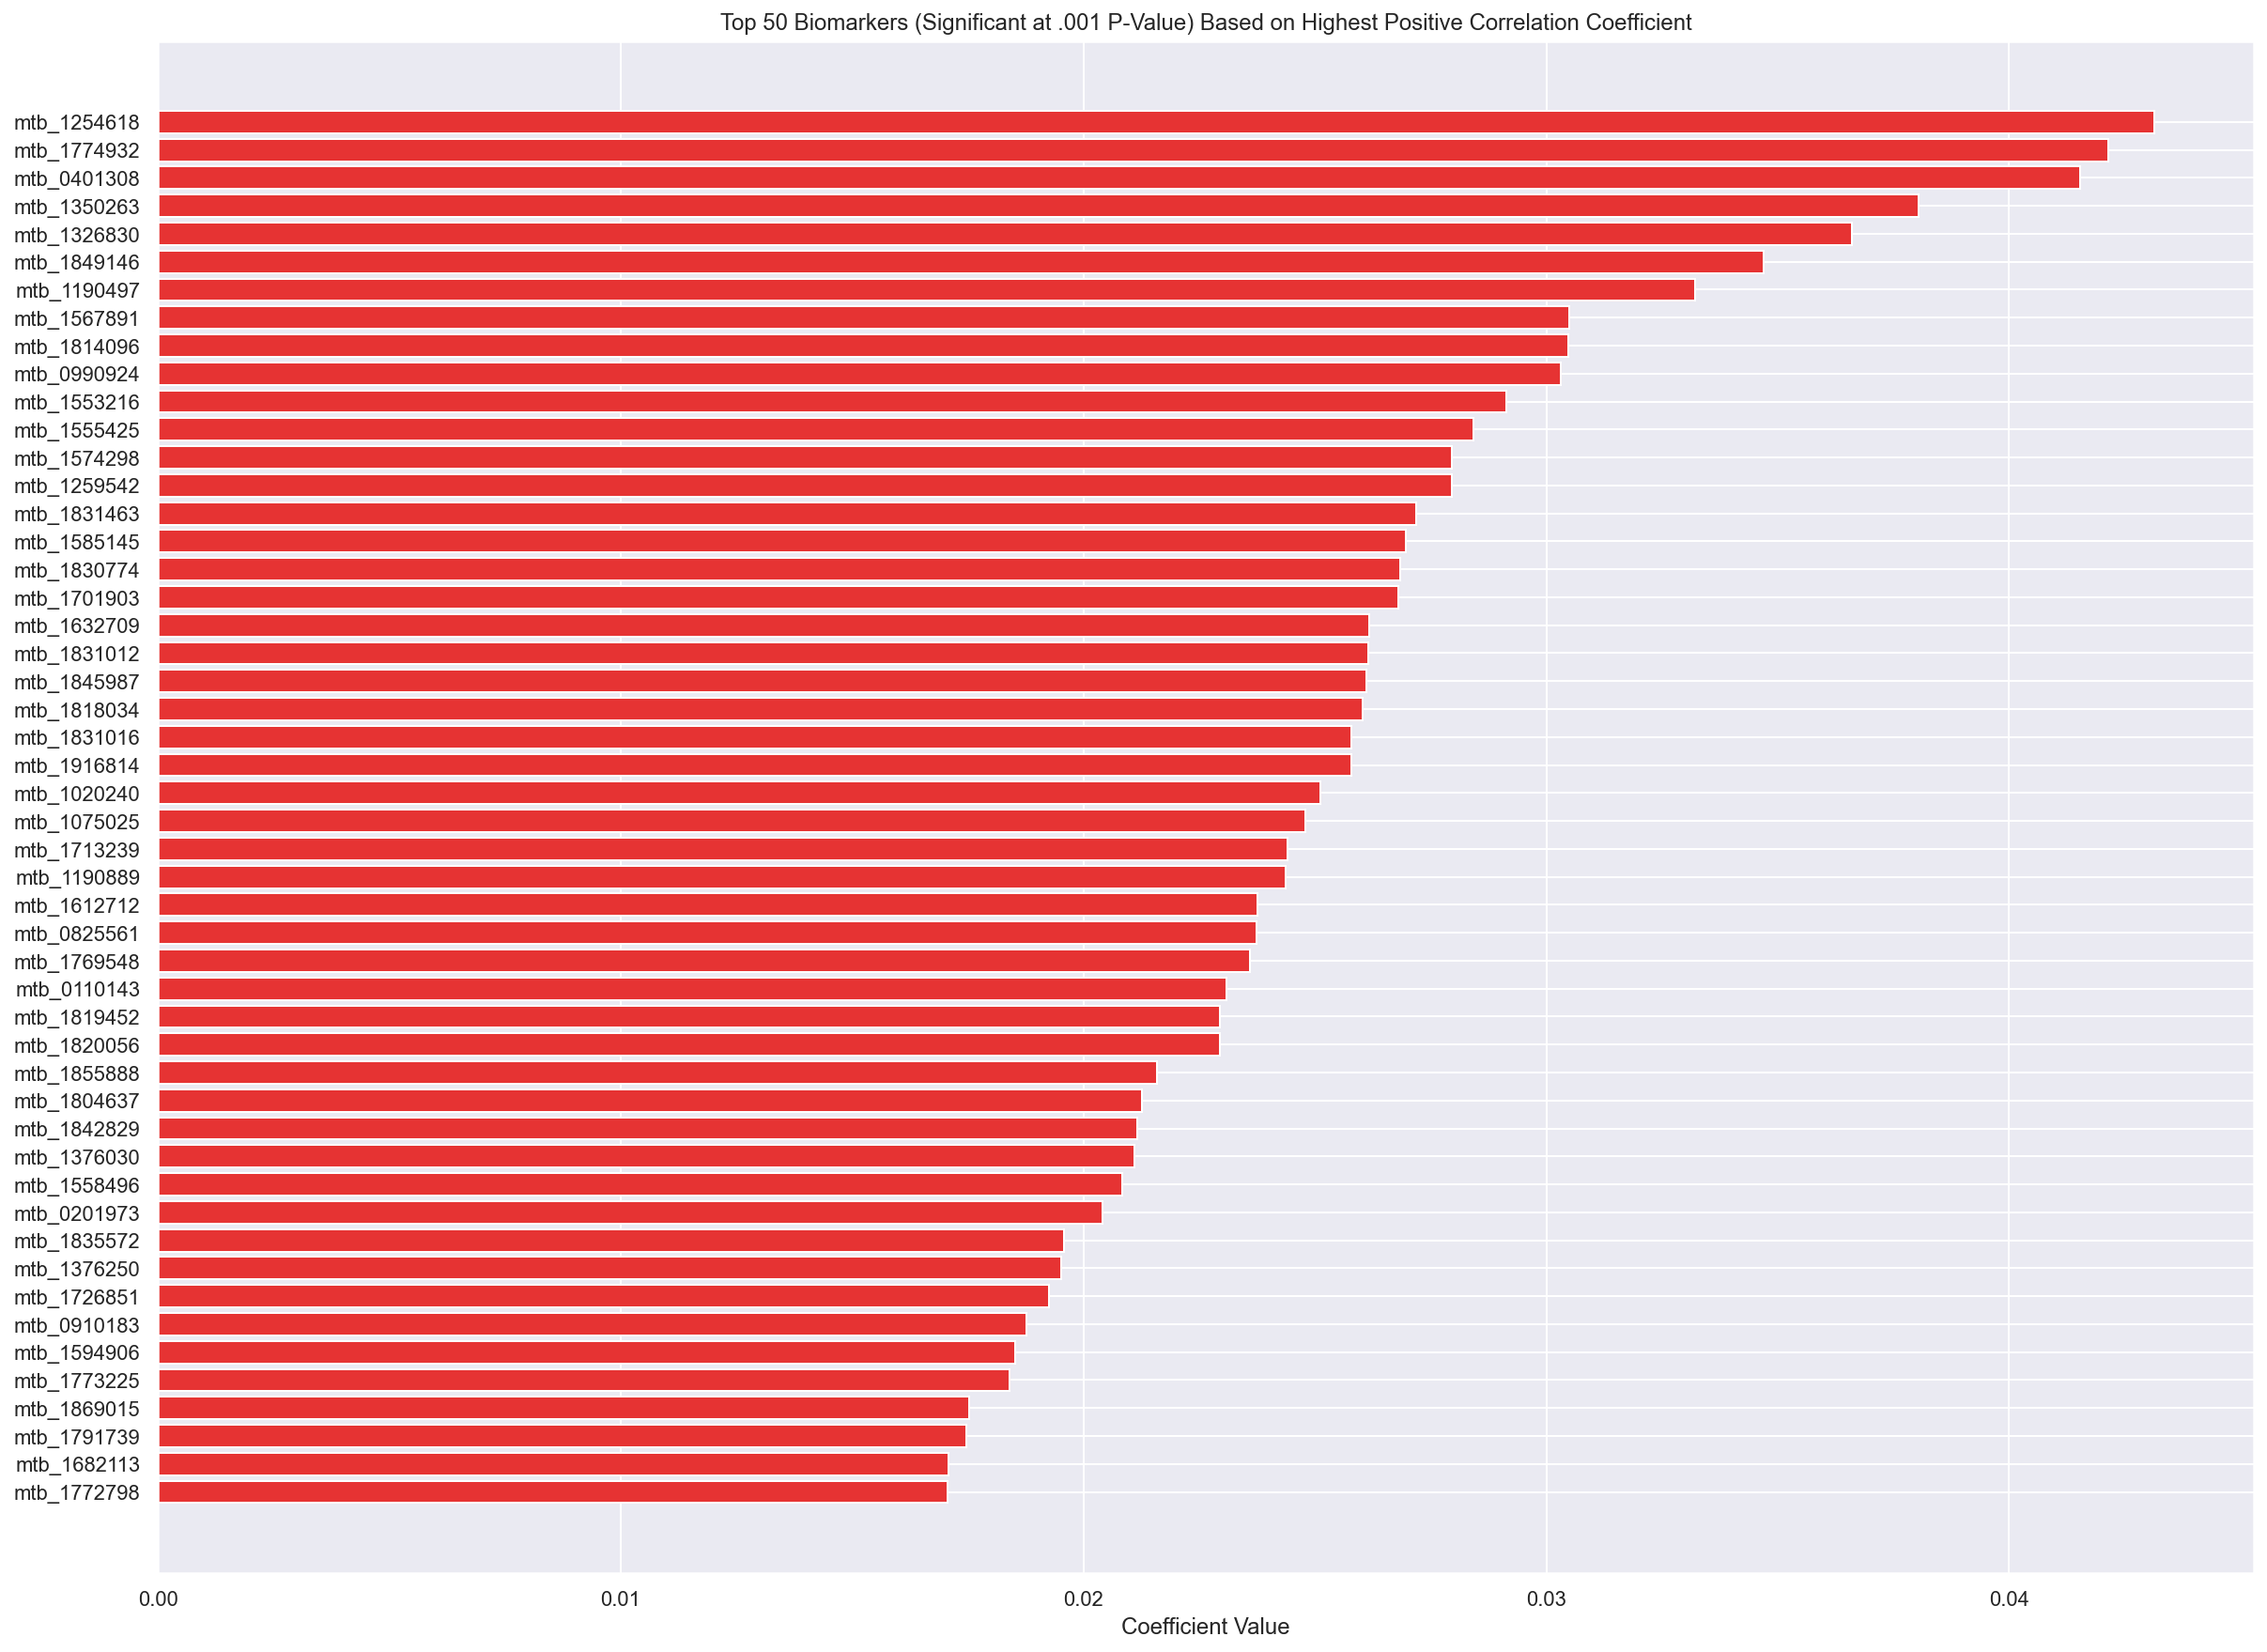

In [153]:
top_50_pos_corr_biomarkers = top_positive_corr_biomarkers.head(50)

plt.figure(figsize=(20, 15))
plt.barh(top_50_pos_corr_biomarkers['biomarker'], top_50_pos_corr_biomarkers['coef'], color=(0.9, 0.2, 0.2))
plt.xlabel('Coefficient Value')
plt.title('Top 50 Biomarkers (Significant at .001 P-Value) Based on Highest Positive Correlation Coefficient')
plt.gca().invert_yaxis()
plt.show()

## C4. Negative Correlation with Incident Diabetes (PROTECTIVE)

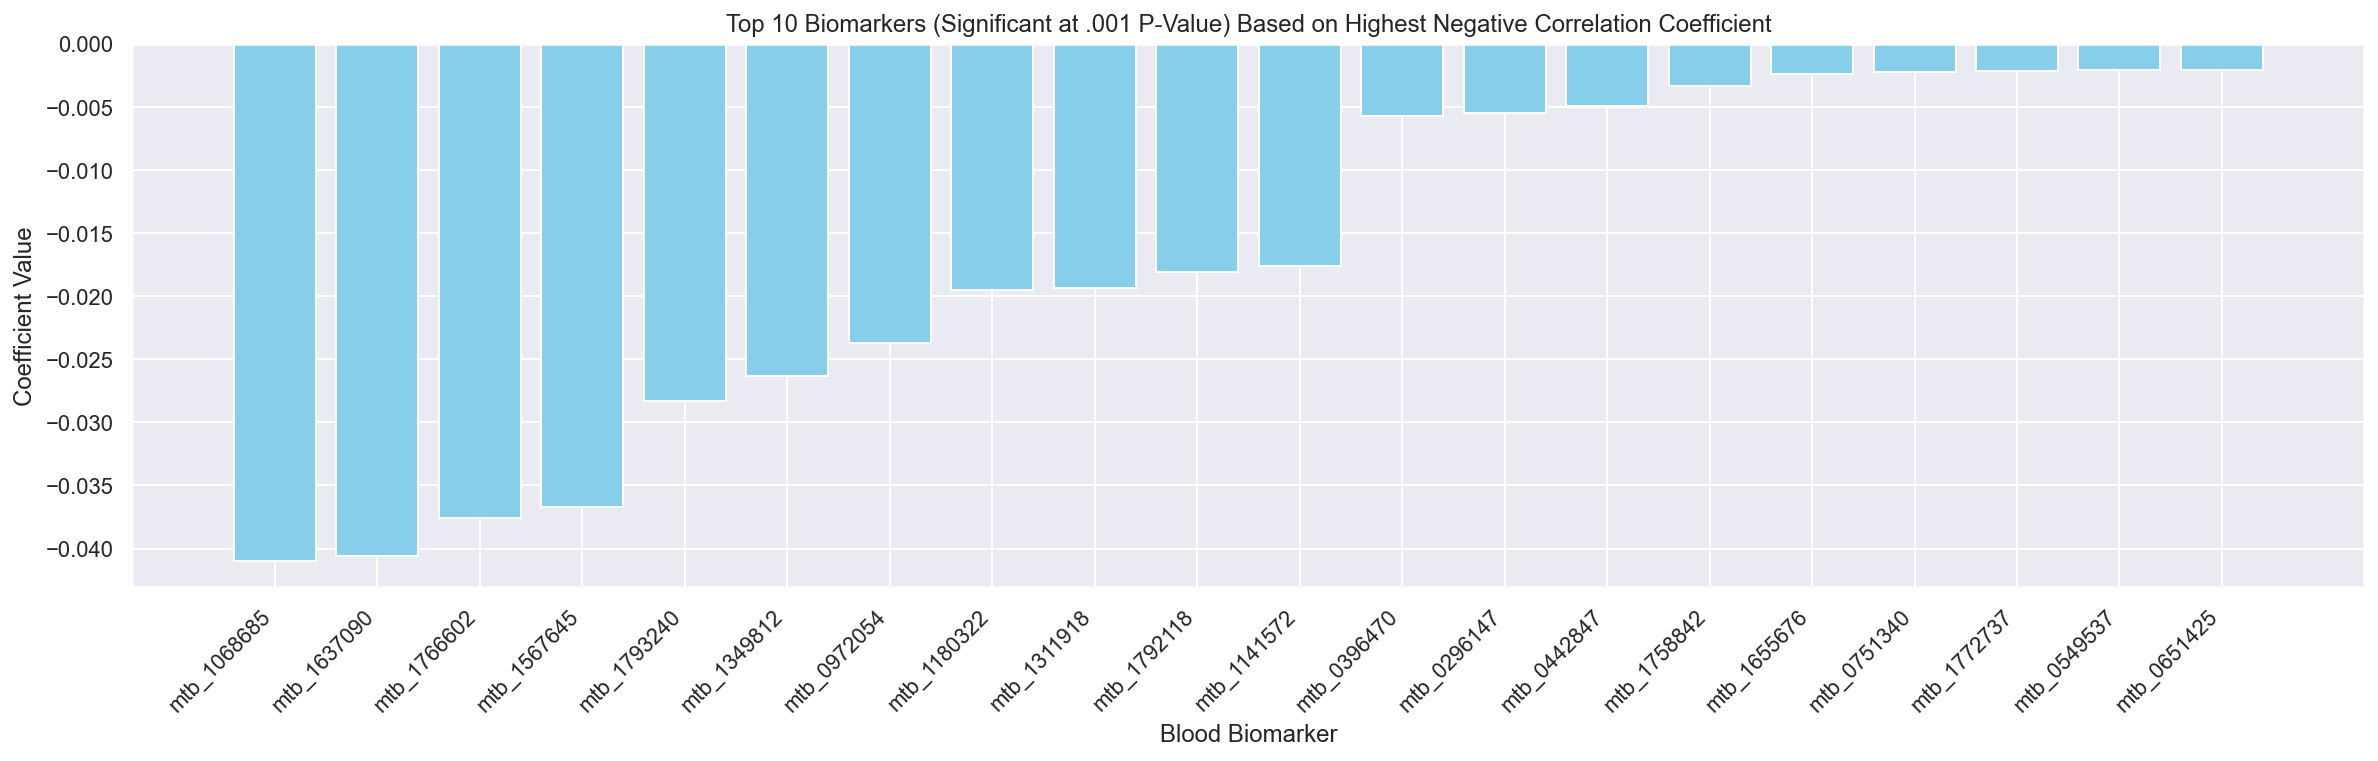

In [164]:
top_20_neg_corr_biomarkers = top_negative_corr_biomarkers.head(20)

plt.figure(figsize=(20, 5))
plt.bar(top_20_neg_corr_biomarkers['biomarker'], top_20_neg_corr_biomarkers['coef'], color='skyblue')
plt.ylabel('Coefficient Value')
plt.xlabel('Blood Biomarker')
plt.title('Top 10 Biomarkers (Significant at .001 P-Value) Based on Highest Negative Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

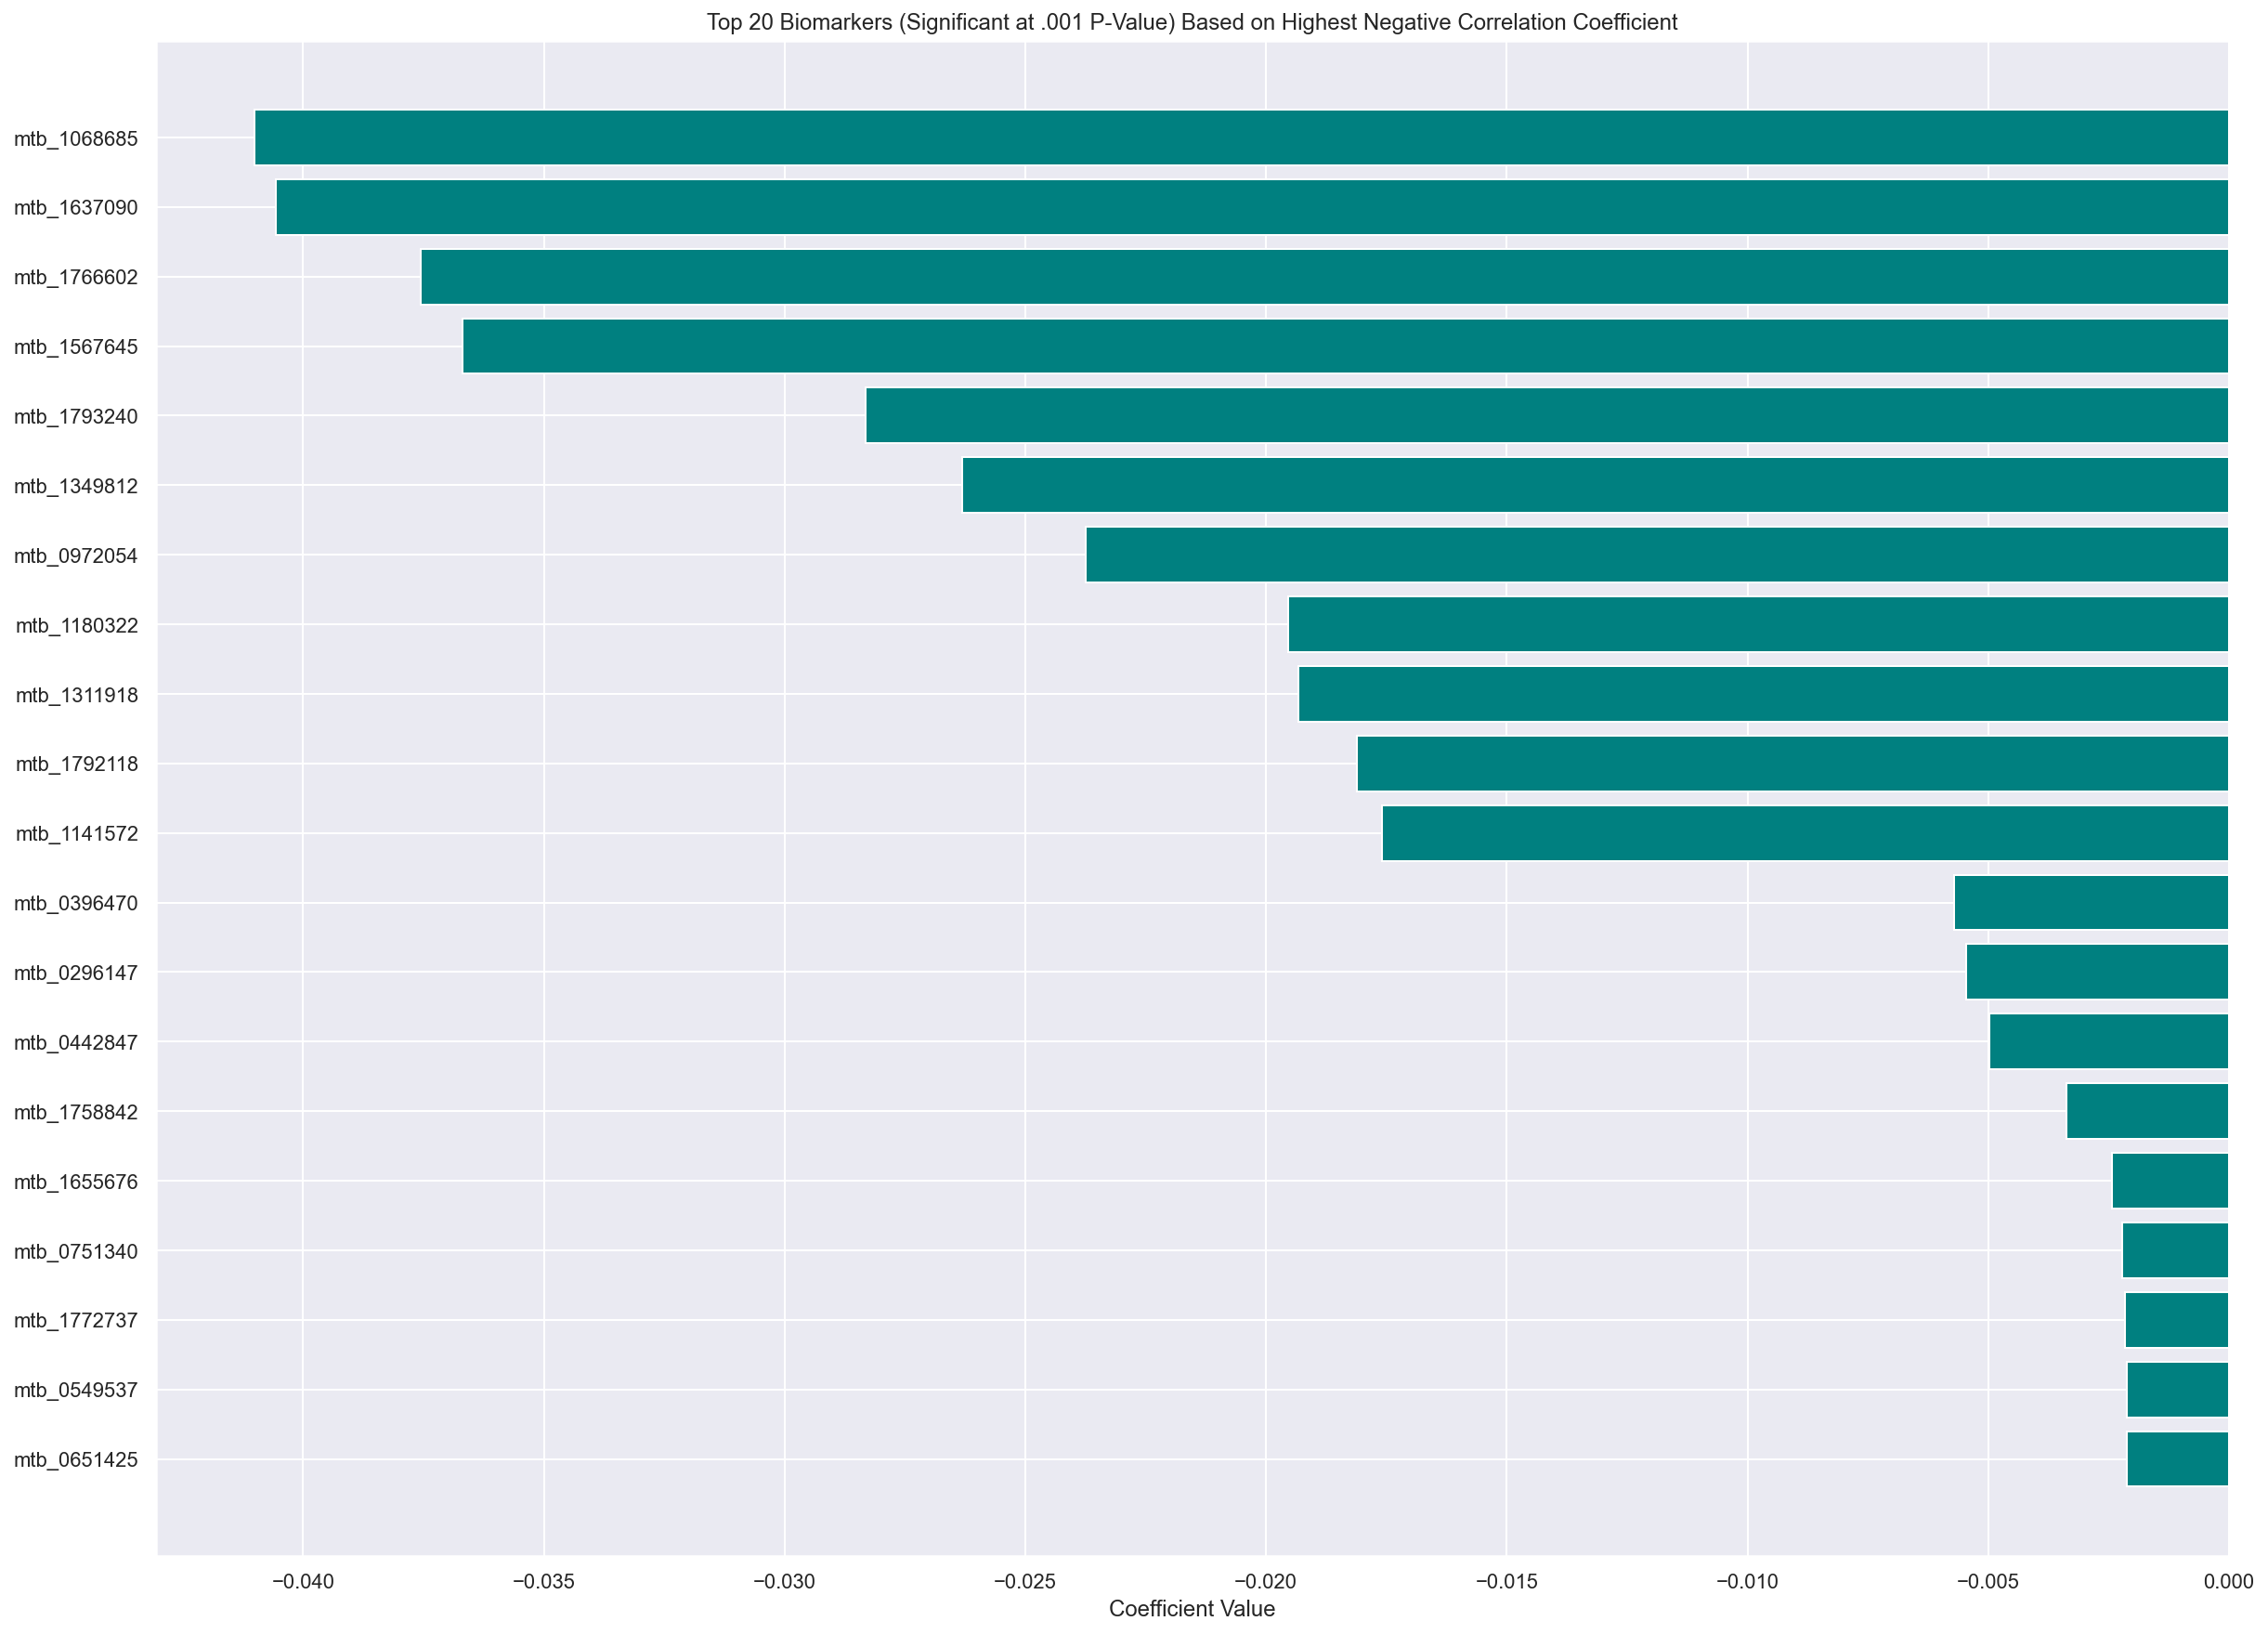

In [159]:
top_20_neg_corr_biomarkers = top_negative_corr_biomarkers.head(20)

plt.figure(figsize=(20, 15))
plt.barh(top_20_neg_corr_biomarkers['biomarker'], top_20_neg_corr_biomarkers['coef'], color='teal')
plt.xlabel('Coefficient Value')
plt.title('Top 20 Biomarkers (Significant at .001 P-Value) Based on Highest Negative Correlation Coefficient')
plt.gca().invert_yaxis()
plt.show()

---

# D. Q2: How can we use blood biomarkers to predict the risk of developing incident diabetes?

Hints: 
- (1) Select the relevant blood biomarkers as features for your classifier. Keep in mind that in clinical settings, it is always difficult to implement a screening test when there are a lot of biomarkers to be measured. 
- (2) Select and train a machine learning model to make predictions
- (3) Evaluate your predictive model.

For our machine learning model, we will incorporate blood biomarkers that are statistically significant at the .001 level.

In [190]:
selected_biomarkers_data = data[['incident_diabetes'] + list(significant_biomarkers_05['biomarker'])]
selected_biomarkers_data

,incident_diabetes,mtb_0019710,mtb_0020812,mtb_0023385,mtb_0025408,mtb_0025572,mtb_0025608,mtb_0030396,mtb_0032732,mtb_0032933,...,mtb_1927454,mtb_1952330,mtb_1963745,mtb_1985184,mtb_1991935,mtb_1997248,mtb_2018298,mtb_2056383,mtb_2094209,mtb_2120885
0,0.0,44738.50,9504.184,18624.87,0.000,13749.86,0.0,27165.97,4090.245,0.0,...,8067.774,71744.47,0.0,23194.040,9604.280,0.000,0.0,0.000,0.000,0.000
1,0.0,82826.64,21842.630,16574.12,393.949,34090.73,0.0,24480.55,0.000,0.0,...,17912.580,0.00,0.0,56593.570,22865.420,0.000,0.0,0.000,0.000,0.000
2,0.0,95169.78,13915.450,13436.33,0.000,15300.68,0.0,17851.81,2029.257,0.0,...,0.000,125321.70,0.0,16107.070,10122.540,0.000,0.0,0.000,0.000,0.000
3,0.0,95722.26,29649.980,5830.32,1922.532,17993.70,0.0,11044.01,0.000,0.0,...,19266.460,84942.08,0.0,29123.100,10720.310,9055.233,0.0,0.000,0.000,0.000
4,0.0,91963.21,27045.690,10724.21,1135.911,22441.84,0.0,19294.46,0.000,0.0,...,13203.170,91254.91,0.0,54482.910,19147.750,0.000,0.0,3906.560,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8286,0.0,35502.37,7291.967,12398.41,0.000,11331.42,0.0,24136.83,3505.875,0.0,...,0.000,145625.00,0.0,0.000,3225.793,0.000,0.0,0.000,0.000,0.000
8287,0.0,86445.55,14939.750,12879.06,5919.530,27203.70,0.0,18765.93,0.000,0.0,...,0.000,34983.27,0.0,29660.910,14091.700,0.000,0.0,4547.782,8478.192,3103.647
8288,0.0,67046.64,21107.470,10248.63,0.000,9512.91,0.0,19699.47,0.000,0.0,...,0.000,40914.24,0.0,22475.970,8228.780,0.000,0.0,4960.176,0.000,0.000
8289,0.0,51289.32,6211.620,10835.28,0.000,26732.42,0.0,29859.98,0.000,0.0,...,4476.600,207477.00,0.0,9453.781,2798.269,0.000,0.0,1451.092,0.000,0.000


In [194]:
X = selected_biomarkers_data.drop(['incident_diabetes'], axis=1)
y = selected_biomarkers_data['incident_diabetes']

#Normalize the data (X) prior to fitting the model
X = X.apply(lambda x:(x-x.min()) / (x.max() - x.min()), axis=0)
X.head()

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Instantiate a logistic regression model
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', max_iter=1000)

#fit the model
logreg.fit(X_train, y_train)

#generate predictions
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [195]:
#How many times was the classifier correct on the training set?
train_residuals = np.abs(y_train - y_hat_train)
print(pd.Series(train_residuals, name="Residuals (counts)").value_counts())
print(pd.Series(train_residuals, name="Residuals (proportions)").value_counts(normalize=True))

0.0    6518
Name: Residuals (counts), dtype: int64
0.0    1.0
Name: Residuals (proportions), dtype: float64


In [196]:
#How many times was the classifier correct on the test set?
test_residuals = np.abs(y_test - y_hat_test)
print(pd.Series(test_residuals, name="Residuals (counts)").value_counts())
print(pd.Series(test_residuals, name="Residuals (proportions)").value_counts(normalize=True))

0.0    1349
1.0     281
Name: Residuals (counts), dtype: int64
0.0    0.827607
1.0    0.172393
Name: Residuals (proportions), dtype: float64
